In [1]:
import pandas as pd
import requests
from collections import defaultdict
import json

### OGC sensorthings API

In [2]:
# analysed endpoint:
argo_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1" 

# explore sparql endpoint: Endpoint https://sparql.ifremer.fr/sextant_seadatanet/query={?query}
# serviceEndpoint: https://sparql.ifremer.fr/sextant_seadatanet/query=
# alias ~ seadatanet domains 

### Analysis results:

- data findable & accessible: 
    - endpoint is a json API,
    - machine accessible but requires knowledge on API structure/model 
    - not all metadata links acessible (see further)

- data granularity goes to data point level
  - single observations are described 

- semantics of metadata 
  - use of standard terms (~ semantic ambiguity), but limited
    - Sensors entity: 'encoding type' field is url (e.g. "http://www.opengis.net/doc/IS/SensorML/2.0")
      but Locations entity: 'encoding type' field is standard term but string
    - ObservedProperties entity: no link to external definitions (definition field itself is a code number/ID)
    - Observations entity: 'result' field -> not clear, result of what? 
    - FeatureOfInterest entity: name is a code --> refers to location where observation was made; --> results in semantic ambiguity for 'result' property of Observations entity (e.g. https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest(61795678), https://docs.ogc.org/is/18-088/18-088.html#featureofinterest
    - Sensors entity: 'metadata' field has url "https://sextant.ifremer.fr/examind" --> unaccessible 
  - properties field with user-annotated properties (~ semantic ambiguity)
  - limited alignment with other standards,vocabs,... 
  
- interoperability: 
    - following the O&M 2.0 standard,IOT-T definition (figure: https://docs.ogc.org/is/18-088/18-088.html#fig-sensing-entities)
    - requires getting to know this standard in order to understand the semantics of the data
  
(sidenotes: @iot.selflink returns 404 - not available - due to missing ')' at end of url)

A typical 'OGC SensorThings' API has following properties:
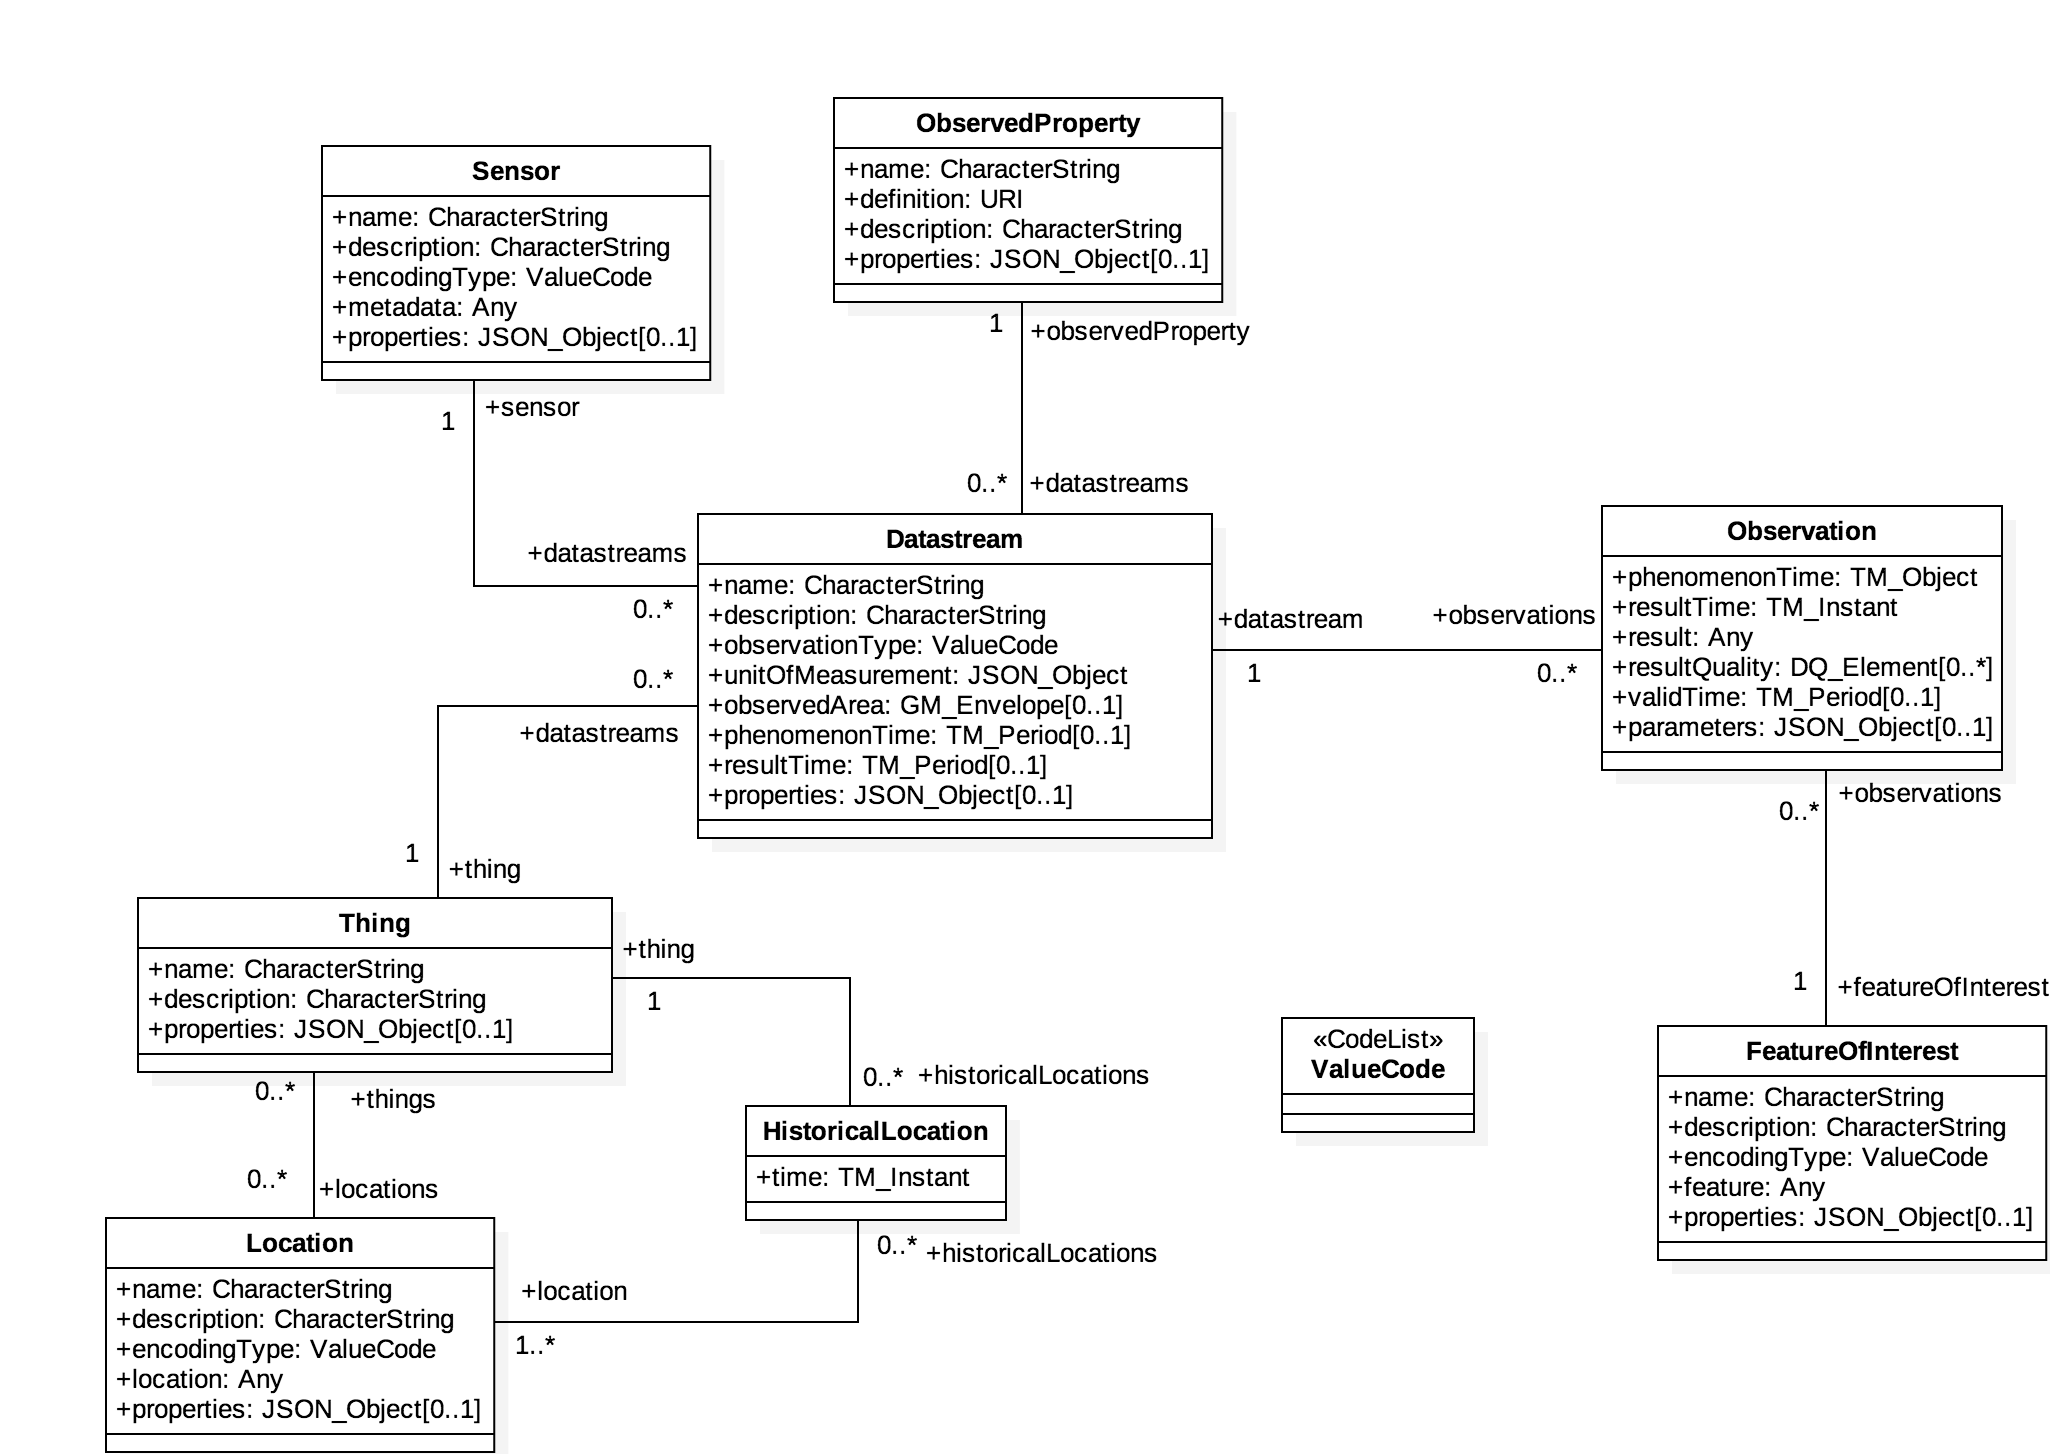

The ARGO SensorThings API is implemented as follows:

![image.png](images/ARGO_SensorThingsAPI.drawio.png)

In [3]:
endpoint_response = requests.get(argo_url).json()

print(f"number of entities described: {len( endpoint_response['value'])}")
entity_names = []
entity_urls = []
for item in endpoint_response['value']:
    item_list = list(item.values())
    entity_names.append(item_list[0])
    entity_urls.append(item_list[-1])
    
    print(f'{item_list[0]}: {item_list[-1]}')


number of entities described: 9
Things: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things
Locations: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Locations
Datastreams: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Datastreams
MultiDatastreams: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/MultiDatastreams
Sensors: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Sensors
Observations: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Observations
ObservedProperties: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties
FeaturesOfInterest: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest
HistoricalLocations: https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations


In [4]:
#Helper function
def summarize_json_keys(data, summary=None, parent_key=""):
    """
    Recursively summarizes all keys in a JSON object.

    :param data: The JSON data (as a Python dictionary or list).
    :param summary: A dictionary to store the summary of keys (default: None).
    :param parent_key: A string representing the parent key (for nested keys).
    :return: A dictionary summarizing the occurrence and types of all keys.
    """
    if summary is None:
        summary = defaultdict(lambda: {"count": 0, "types": set(), "example": ""})

    if isinstance(data, dict):
        for key, value in data.items():
            # Create a full key path for nested keys
            full_key = f"{parent_key}.{key}" if parent_key else key
            summary[full_key]["count"] += 1
            summary[full_key]["types"].add(type(value).__name__)
            summary[full_key]["example"] = value
            summarize_json_keys(value, summary, full_key)

    elif isinstance(data, list):
        for item in data:
            summarize_json_keys(item, summary, parent_key)

    return summary

In [5]:
# Things URL
things_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things"

# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while things_url:
    response = requests.get(things_url)
    json_data = response.json()

    # Update the summary with the current page's data
    summary = summarize_json_keys(json_data, summary)

    # Update the URL to the next page
    things_url = json_data.get("@iot.nextLink")

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")
    

Key: value, Count: 33, Types: list, Example value: '[{'name': 'SEVASTOPOL (R/V; call sign UWHO;', 'description': 'SEVASTOPOL (R/V; call sign UWHO; built 1951; Murmansk PINRO)', 'properties': {'type': 'Profile'}, '@iot.id': 'UWHO', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things(UWHO)', 'HistoricalLocations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things(UWHO)/HistoricalLocations', 'Datastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things(UWHO)/Datastreams', 'Locations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things(UWHO)/Locations', 'MultiDatastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Things(UWHO)/MultiDatastreams'}, {'name': 'ORLOVKA (F/V; call sign UWIR; bu', 'description': 'ORLOVKA (F/V; call sign UWIR; built 1951)', 'properties': {'type': 'Profile'}, '@iot.id': 'UWIR', '@iot.selfLink': 'https://

In [46]:
#Locations: 
loc_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Locations"

# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while loc_url:
    response = requests.get(loc_url)
    json_data = response.json()

    # Update the summary with the current page's data
    summary = summarize_json_keys(json_data, summary)

    # Update the URL to the next page
    loc_url = json_data.get("@iot.nextLink")

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

Key: value, Count: 33, Types: list, Example value: '[{'name': 'EXO11323', 'description': '', 'encodingType': 'application/vnd.geo+json', 'location': {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-12.13, 35.17]}, 'properties': {}}, '@iot.id': 'EXO11323', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Locations(EXO11323)', 'Things@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Locations(EXO11323)/Things', 'HistoricalLocations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Locations(EXO11323)/HistoricalLocations'}, {'name': 'EXO11245', 'description': '', 'encodingType': 'application/vnd.geo+json', 'location': {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-53.55, 43.25]}, 'properties': {}}, '@iot.id': 'EXO11245', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Locations(EXO11245)', 'Things@iot.navigationLink': 'https://sextant.ifremer.fr

In [57]:
#Datastreams: 
datastr_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Datastreams"
print(datastr_url)

# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set(), "example": None})

# Fetch data and summarize keys across all pages
while datastr_url:
    try:
        response = requests.get(datastr_url)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code}")
            break

        # Check if the response content is empty
        if not response.content.strip():
            print("Empty response received")
            break

        # Attempt to parse the JSON
        try:
            json_data = response.json()
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            print(f"Response content: {response.text[:100]}...")  # Print a snippet of the response for debugging
            break

        # Update the summary with the current page's data
        summary = summarize_json_keys(json_data, summary)

        # Update the URL to the next page
        datastr_url = json_data.get("@iot.nextLink")

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        break

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Datastreams
Request failed with status code 502
Key: value, Count: 21, Types: list, Example value: '[{'description': '', 'unitOfMeasurement': {}, 'observationType': 'http://www.opengis.net/def/observationType/OGC-OM/2.0/OM_Measurement', 'observedArea': {'type': 'Polygon', 'coordinates': [[[113.7931, -43.2344], [113.7931, -42.1964], [116.1441, -42.1964], [116.1441, -43.2344], [113.7931, -43.2344]]]}, 'phenomenonTime': '2024-02-25T03:36:40Z/2024-08-07T14:37:53Z', 'resultTime': '2024-02-25T03:36:40Z/2024-08-07T14:37:53Z', '@iot.id': 'urn:observation:template:1902651-584', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Datastreams(urn:observation:template:1902651-584)', 'Thing@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Datastreams(urn:observation:template:1902651-584)/Things', 'Sensor@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Datastreams(

In [6]:
#MultiDatastreams: 
multidatastr_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/MultiDatastreams"
print(multidatastr_url)
# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while multidatastr_url:
    response = requests.get(multidatastr_url)

    if response.status_code != 502:
        json_data = response.json()
        # Update the summary with the current page's data
        summary = summarize_json_keys(json_data, summary)

        # Update the URL to the next page
        multidatastr_url = json_data.get("@iot.nextLink")
    else:
        print(f"{response.status_code} for {multidatastr_url} - no json retrievable")
        multidatastr_url = None
        

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/MultiDatastreams
502 for https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/MultiDatastreams - no json retrievable


In [13]:
#Sensors: 
sensor_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Sensors"
print(sensor_url)
# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while sensor_url:
    response = requests.get(sensor_url)
    json_data = response.json()

    # Update the summary with the current page's data
    summary = summarize_json_keys(json_data, summary)

    # Update the URL to the next page
    sensor_url = json_data.get("@iot.nextLink")

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Sensors
Key: value, Count: 33, Types: list, Example value: '[{'description': 'SEVASTOPOL (R/V; call sign UWHO; built 1951; Murmansk PINRO)', 'name': 'SEVASTOPOL (R/V; call sign UWHO;', 'encodingType': 'http://www.opengis.net/doc/IS/SensorML/2.0', 'metadata': 'https://sextant.ifremer.fr/examind', '@iot.id': 'UWHO', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Sensors(UWHO)', 'Datastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Sensors(UWHO)/Datastreams', 'MultiDatastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Sensors(UWHO)/MultiDatastreams'}, {'description': 'ORLOVKA (F/V; call sign UWIR; built 1951)', 'name': 'ORLOVKA (F/V; call sign UWIR; bu', 'encodingType': 'http://www.opengis.net/doc/IS/SensorML/2.0', 'metadata': 'https://sextant.ifremer.fr/examind', '@iot.id': 'UWIR', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/

In [7]:
#Observations: 
obs_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Observations"
print(obs_url)
# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while obs_url:
    response = requests.get(obs_url)

    if response.status_code != 502:
        json_data = response.json()
        summary = summarize_json_keys(json_data, summary)
        # Update the URL to the next page
        obs_url = json_data.get("@iot.nextLink")

    else:
        print(f"{response.status_code} for {obs_url} - no json retrievable")
        obs_url = None

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")


https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Observations
502 for https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/Observations - no json retrievable


In [8]:
#ObservedProperties: 
prop_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties"
print(prop_url)
# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while prop_url:
    response = requests.get(prop_url)
    json_data = response.json()

    # Update the summary with the current page's data
    summary = summarize_json_keys(json_data, summary)

    # Update the URL to the next page
    prop_url = json_data.get("@iot.nextLink")

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties
Key: value, Count: 1, Types: list, Example value: '[{'name': 'Depth', 'definition': '9', 'description': '', 'properties': {}, '@iot.id': '9', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties(9)', 'Datastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties(9)/Datastreams', 'MultiDatastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties(9)/MultiDatastreams'}, {'name': 'Dissolved oxygen', 'definition': '11', 'description': '', 'properties': {}, '@iot.id': '11', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties(11)', 'Datastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/ObservedProperties(11)/Datastreams', 'MultiDatastreams@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis

In [48]:
#FeaturesOfInterest: 
foi_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest"
print(foi_url)
# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while foi_url:
    response = requests.get(foi_url)
    json_data = response.json()

    # Update the summary with the current page's data
    summary = summarize_json_keys(json_data, summary)

    # Update the URL to the next page
    foi_url = json_data.get("@iot.nextLink")

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest
Key: value, Count: 10, Types: list, Example value: '[{'name': '38127577', 'encodingType': 'application/vnd.geo+json', 'feature': {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-1.58333, 61.31667]}, 'properties': {}}, 'properties': {}, '@iot.id': '38127577', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest(38127577)', 'Observations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest(38127577)/Observations'}, {'name': '61966968', 'encodingType': 'application/vnd.geo+json', 'feature': {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [33.7, 69.38]}, 'properties': {}}, 'properties': {}, '@iot.id': '61966968', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/FeaturesOfInterest(61966968)', 'Observations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriol

In [49]:
#HistoricalLocations: 
histloc_url = "https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations"
print(histloc_url)
# Initialize the summary dictionary
summary = defaultdict(lambda: {"count": 0, "types": set()})

# Fetch data and summarize keys across all pages
while histloc_url:
    response = requests.get(histloc_url)
    json_data = response.json()

    # Update the summary with the current page's data
    summary = summarize_json_keys(json_data, summary)

    # Update the URL to the next page
    histloc_url = json_data.get("@iot.nextLink")

# Display the summary of all keys
for key, info in summary.items():
    print(f"Key: {key}, Count: {info['count']}, Types: {', '.join(info['types'])}, Example value: '{info['example']}'")

https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations
Key: value, Count: 1, Types: list, Example value: '[{'@iot.id': 'GXBH--4217011200000', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations(GXBH--4217011200000)', 'time': '1836-05-15T00:00:00Z', 'Locations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations(GXBH--4217011200000)/Locations', 'Thing@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations(GXBH--4217011200000)/Things'}, {'@iot.id': 'EXOC1354--4094668800000', '@iot.selfLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations(EXOC1354--4094668800000)', 'time': '1840-03-31T00:00:00Z', 'Locations@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/coriolis/v1.1/HistoricalLocations(EXOC1354--4094668800000)/Locations', 'Thing@iot.navigationLink': 'https://sextant.ifremer.fr/examind/WS/sts/c

### Argo metadata & data API

In [ ]:
argo_metadata_url = "https://fleetmonitoring.euro-argo.eu/floats"
argo_data_url = "https://fleetmonitoring.euro-argo.eu"

#### Notes/findings:
- both json API, no RDF ~ not directly machine accessible, requires getting to know the data model
- Swagger APi documentation avaiable 
  - the semantics are not clear
  - requires knowledge on the wmo-codes, platform-codes, ... 
- limited/no use of standard terms in output of '/floats' path  
  
- data granularity is unclear

In [ ]:
metadata_response = requests.get(argo_metadata_url).json()

In [ ]:
metadata_response[0]

In [ ]:
metadata_response[10]

In [ ]:
data_response = requests.get(argo_data_url).json()

In [ ]:
data_response[0]

In [ ]:
data_response[10]